In [1]:
%matplotlib inline

from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog
import detectron2.data.transforms as T
from detectron2.structures.image_list import ImageList
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetMapper
from detectron2.data import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.samplers import TrainingSampler
from detectron2.modeling.proposal_generator.proposal_utils import add_ground_truth_to_proposals
from detectron2.modeling.sampling import subsample_labels
from detectron2.structures import Boxes, Instances, pairwise_iou
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.utils.visualizer import Visualizer

from fsdet.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from fsdet.evaluation import (
    COCOEvaluator, DatasetEvaluators, LVISEvaluator, PascalVOCDetectionEvaluator, verify_results)
from fsdet.evaluation import (
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)
import cv2
import torch, torchvision
import logging
import os
from sklearn import svm
from joblib import dump, load
from detectron2.layers import nonzero_tuple
import numpy as np

logging.basicConfig(level=logging.INFO)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Load pretrained detection model and Prediect directly

## Load models of DNN and SVM

In [2]:
cfg = get_cfg()
cfg.merge_from_file('configs/test_unfreeze_lastfews.yaml')
model = build_model(cfg)  # returns a torch.nn.Module

model.eval()
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

# ckpt_file = 'checkpoints/coco/base_model/model_final.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_freeze_last_cos/model_final.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_freeze_last_fc/model_final.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_unfreeze_lastfews/model_final.pth'
ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_unfreeze_whole/model_0015999.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_airplane_unfreeze_whole/model_0029999.pth'
DetectionCheckpointer(model).load(ckpt_file)

# clf = load('svm_results/svm_model_finetuned_prop_base.joblib') 
# clf = load('svm_results/svm_model_finetuned_prop_lastfew.joblib') 
# clf = load('svm_results/svm_model_finetuned_prop_whole.joblib') 
run_rcnn = False
ft_extractor_type = ckpt_file.split('/')[-2]
shots_num = 100
class_name = 'person'
file_name = 'svm_{}_{}_{}.joblib'.format(ft_extractor_type, shots_num, class_name)
clf = load('svm_results_0216/'+ file_name)


INFO:fvcore.common.checkpoint:Loading checkpoint from checkpoints/coco/faster_rcnn/30shot_person_unfreeze_whole/model_0015999.pth


In [3]:
# define some functions for preprocessing
assert len(cfg.MODEL.PIXEL_MEAN) == len(cfg.MODEL.PIXEL_STD)
num_channels = len(cfg.MODEL.PIXEL_MEAN)
device = 'cuda'
pixel_mean = (
    torch.Tensor(cfg.MODEL.PIXEL_MEAN)
    .to(device)
    .view(num_channels, 1, 1)
)
pixel_std = (
    torch.Tensor(cfg.MODEL.PIXEL_STD)
    .to(device)
    .view(num_channels, 1, 1)
)
normalizer = lambda x: (x - pixel_mean) / pixel_std

## Register dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
json_dir = 'datasets/coco_experiments/seed1/full_box_30shot_person_trainval.json'
image_dir = 'datasets/coco/trainval2014'
register_coco_instances("30shot_person_train", {}, json_dir, image_dir)

json_dir = 'datasets/coco_experiments/seed1/full_box_{}shot_{}_test.json'.format(1000, class_name)
image_dir = 'datasets/coco/trainval2014'
testset_name = "{}_test".format(class_name)
register_coco_instances(testset_name, {}, json_dir, image_dir)

# json_dir = 'datasets/cocosplit/datasplit/5k.json'
# image_dir = 'datasets/coco/trainval2014'
# register_coco_instances("5k_test", {}, json_dir, image_dir)

# testset_name = "5k_test"

## Difference between some dataloader

In [5]:
# data_loader_train = build_detection_train_loader(cfg)
# data_loader_train_it = iter(data_loader_train)
# data = next(data_loader_train_it)
# print(len(data))
# print(data[0]['image'].shape)
# print(data)

In [6]:
# data_loader_test = build_detection_test_loader(cfg, "1000shot_person_test")
# data_loader_test_it = iter(data_loader_test)
data_loader_test = build_detection_test_loader(cfg, testset_name)
data_loader_test_it = iter(data_loader_test)

INFO:detectron2.data.datasets.coco:Loaded 239 images in COCO format from datasets/coco_experiments/seed1/full_box_1000shot_person_test.json
INFO:detectron2.data.build:Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 1000         |
|            |              |
INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
INFO:detectron2.data.common:Serializing 239 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 0.67 MiB


In [7]:
data = next(data_loader_test_it)
print(len(data))
print(data[0]['image'].shape)
print(len(data_loader_test))

1
torch.Size([3, 800, 1166])
239


In [8]:
# transform_gen = T.ResizeShortestEdge(
#             [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
#             cfg.INPUT.MAX_SIZE_TEST,
#             )
# print([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
#             cfg.INPUT.MAX_SIZE_TEST)
# data_loader = build_detection_train_loader(DatasetCatalog.get("1000shot_person_test"),
#                                            mapper=DatasetMapper(cfg, is_train=False, augmentations=[transform_gen]),
#                                            total_batch_size = 10)
# data_loader_it = iter(data_loader)
# data = next(data_loader_it)
# print(len(data))
# print(data[0]['image'].shape)
# print(data)

## the type of dataloader is different 'AspectRatio Grouped Dataset' (don't know the reason) 

In [9]:
# run one iter
# evaluator = COCOEvaluator("1000shot_person_test", cfg, True, output_dir = cfg.OUTPUT_DIR)
# with torch.no_grad():
#     inputs = data
#     outputs = model(inputs)
#     evaluator.reset()
#     evaluator.process(inputs, outputs)
#     results = evaluator.evaluate()


In [10]:
# default test 
# run_rcnn = True
if run_rcnn:
    evaluator = COCOEvaluator(testset_name, cfg, True, output_dir = cfg.OUTPUT_DIR)
    evaluator.reset()
    inference_on_dataset(model, data_loader_test, evaluator)

# Run detector step by step (should have same results)

In [11]:
if run_rcnn:
    evaluator = COCOEvaluator(testset_name, cfg, True, output_dir = cfg.OUTPUT_DIR)
    evaluator.reset()

    training = False
    save_results = False
    box2box_transform = Box2BoxTransform(
                weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS
            )
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA
    # test_score_thresh        = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_score_thresh        = 0.5
    test_nms_thresh          = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    test_detections_per_img  = cfg.TEST.DETECTIONS_PER_IMAGE


    with torch.no_grad():
        for idx, inputs in enumerate(data_loader_test):
            #     batched_inputs = data
            batched_inputs = inputs
            ###################################    
            #     outputs = model(inputs)     #
            #---------------------------------# 

            # Normalize, pad and batch the input images. (Preprocess_image)
            images = [x["image"].to('cuda') for x in batched_inputs]
            images = [normalizer(x) for x in images]
            images = ImageList.from_tensors(
                images, model.backbone.size_divisibility
            )

            # forward
            features = model.backbone(images.tensor)
    #         print('features shape:', features['p3'].shape)
            proposals, _ = model.proposal_generator(images, features)
    #         print('proposal num per img:', proposals_list[0].objectness_logits.shape)


            #     results, _ = model.roi_heads(images, features, proposals)
            #     print('\ninstance for image 0:', results[0], '\n')

            # run roi_heads step by step
            if training:
            #         proposals = [proposal for proposal in proposals]
                targets = [d['instances'].to('cuda') for d in data]
                proposals = model.roi_heads.label_and_sample_proposals(proposals, targets)

            box_features = model.roi_heads.box_pooler(
                [features[f] for f in ["p2", "p3", "p4", "p5"]], [x.proposal_boxes for x in proposals]
            )
    #         print(box_features.shape)
            box_features = model.roi_heads.box_head(box_features)
    #         print(box_features.shape)

            pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(
                box_features
            )
    #         print('pred_class_logits', pred_class_logits[:3])
    #         print('pred_proposal_deltas', pred_proposal_deltas.shape)

            outputs = FastRCNNOutputs(
                box2box_transform,
                pred_class_logits,
                pred_proposal_deltas,
                proposals,
                smooth_l1_beta,
            )

            results, _ = outputs.inference(
                    test_score_thresh,
                    test_nms_thresh,
                    test_detections_per_img,
            )

            # postprocess: resize images
            processed_results = []
            for results_per_image, input_per_image, image_size in zip(
                results, batched_inputs, images.image_sizes
            ):
                height = input_per_image.get("height", image_size[0])
                width = input_per_image.get("width", image_size[1])
                r = detector_postprocess(results_per_image, height, width)
                processed_results.append({"instances": r})
    #         print('postprocessed instance for image 0:\n', processed_results[0], '\n')
    ###################################  

            # evaluate
            evaluator.process(inputs, processed_results)
            save_results = True
            if save_results:
                # visualizer
                # inputs should be only one image
                raw_image = cv2.imread(batched_inputs[0]['file_name'])
                result_show = processed_results[0]["instances"]
                v = Visualizer(raw_image,
                                metadata=MetadataCatalog.get(testset_name), 
                                scale=1.0, 
                                instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
                    )
                v = v.draw_instance_predictions(result_show.to("cpu"))

                folder_name = './test_0216/det_last_fc_0.5/'
                os.makedirs(folder_name, exist_ok=True)
                det_img_dir = folder_name + str(idx) + '.jpg'
                cv2.imwrite(det_img_dir, v.get_image())
        eval_results = evaluator.evaluate()

# Add SVM classifier as the final layer

0.5 0.5 100


/home/cloudlet/work/few-shot-object-detection/fsdet/modeling/roi_heads/fast_rcnn.py:115: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()
INFO:fsdet.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:fsdet.evaluation.coco_evaluation:Saving results to checkpoints/coco/faster_rcnn/test_0215/coco_instances_results.json
INFO:fsdet.evaluation.coco_evaluation:Evaluating predictions ...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:fsdet.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 18.337 | 42.884 | 12.980 | 10.582 | 23.060 | 30.587 |


DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

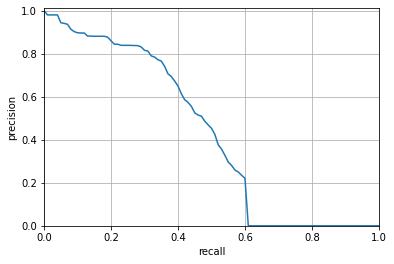

In [12]:
evaluator = COCOEvaluator(testset_name, cfg, True, output_dir = cfg.OUTPUT_DIR)
evaluator.reset()
training = False
box2box_transform = Box2BoxTransform(
            weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS
        )
smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA
# test_score_thresh        = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
test_score_thresh        = 0.5
test_nms_thresh          = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
test_detections_per_img  = cfg.TEST.DETECTIONS_PER_IMAGE
print(test_score_thresh, test_nms_thresh, test_detections_per_img)

with torch.no_grad():
    for idx, inputs in enumerate(data_loader_test):
        #     batched_inputs = data
        batched_inputs = inputs
    ###################################    
    #     outputs = model(inputs)     #
    #---------------------------------# 

        # Normalize, pad and batch the input images. (Preprocess_image)
        images = [x["image"].to('cuda') for x in batched_inputs]
        images = [normalizer(x) for x in images]
        images = ImageList.from_tensors(
            images, model.backbone.size_divisibility
        )

        # forward
        features = model.backbone(images.tensor)
#         print('features shape:', features['p3'].shape)
        proposals, _ = model.proposal_generator(images, features)
#         print('proposal num per img:', proposals[0].objectness_logits.shape) # 1000 proposals


    #     results, _ = model.roi_heads(images, features, proposals)
    #     print('\ninstance for image 0:', results[0], '\n')

        # run roi_heads step by step
        if training:
    #         proposals = [proposal for proposal in proposals]
            targets = [x['instances'].to('cuda') for x in batched_inputs]
            proposals = model.roi_heads.label_and_sample_proposals(proposals, targets)

        box_features = model.roi_heads.box_pooler(
            [features[f] for f in ["p2", "p3", "p4", "p5"]], [x.proposal_boxes for x in proposals]
        )
#         print(box_features.shape)
        box_features = model.roi_heads.box_head(box_features)
#         print(box_features.shape)

        pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(
            box_features
        )
#         print('pred_class_logits', pred_class_logits[:3])
#         print('pred_proposal_deltas', pred_proposal_deltas.shape)

        outputs = FastRCNNOutputs(
            box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            smooth_l1_beta,
        )

        results, _ = outputs.inference(
                test_score_thresh,
                test_nms_thresh,
                test_detections_per_img,
        )

        # postprocess: resize images
        processed_results = []
        for results_per_image, input_per_image, image_size in zip(
            results, batched_inputs, images.image_sizes
        ):
            height = input_per_image.get("height", image_size[0])
            width = input_per_image.get("width", image_size[1])
            r = detector_postprocess(results_per_image, height, width)
            processed_results.append({"instances": r})
#         print('postprocessed instance for image 0:\n', processed_results[0], '\n')

        # SVM 
        X = box_features.to('cpu').detach().numpy()
#         y_hat = clf.predict(X)
        pred_class_logits_svm = clf.predict_log_proba(X)
#         pred_class_logits_svm = np.zeros((pred_class_logits.shape))
#         for i in range(y_hat.shape[0]):
#             # if y_hat=1, background; if y_hat=0, person
#             pred_class_logits_svm[i][0] = 1 - y_hat[i]
#             pred_class_logits_svm[i][-1] = y_hat[i]
        pred_class_logits_svm = torch.from_numpy(pred_class_logits_svm).to('cuda')
#         print(y_hat.shape)
#         print(pred_class_logits_svm[:3])

        outputs_svm = FastRCNNOutputs(
            box2box_transform,
            pred_class_logits_svm,
            pred_proposal_deltas,
            proposals,
            smooth_l1_beta,
        )

        pred_instances_svm, _ = outputs_svm.inference(
                test_score_thresh,
                test_nms_thresh,
                test_detections_per_img,
        )

        processed_results_svm = []
        for results_per_image, input_per_image, image_size in zip(
            pred_instances_svm, batched_inputs, images.image_sizes
        ):
            height = input_per_image.get("height", image_size[0])
            width = input_per_image.get("width", image_size[1])
            r = detector_postprocess(results_per_image, height, width)
            processed_results_svm.append({"instances": r})
#         print('\n\nSVM postprocessed instance for image 0:\n', processed_results_svm[0], '\n')  
    
###################################  
        # evaluate
        evaluator.process(inputs, processed_results_svm)
        save_results = False
        if save_results:
            # visualizer
            # inputs should be only one image
            raw_image = cv2.imread(batched_inputs[0]['file_name'])
            result_show = processed_results_svm[0]["instances"]
            v = Visualizer(raw_image,
                            metadata=MetadataCatalog.get("1000shot_person_test"), 
                            scale=1.0, 
                            instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
                )
            v = v.draw_instance_predictions(result_show.to("cpu"))
        
#             det_img_folder = time.strftime("%d_%H_%M/")
            folder_name = './test_0216/svm_{}_{}_{}_{}/'.format(ft_extractor_type, shots_num, class_name, test_score_thresh)
            os.makedirs(folder_name, exist_ok=True)
            det_img_dir = folder_name + str(idx) + '.jpg'
            cv2.imwrite(det_img_dir, v.get_image())
    results = evaluator.evaluate()